Notes:
- Re-run everything including non-preprocessed with new RegEx
- Information extraction: With time: Train a simple model: 
  - Create dataset: X: OCR output, Y1: CIF, Y2: Document no.
  - Split
  - Train model
  - Test model

# Installing packages 

In [ ]:
!sudo apt install tesseract-ocr-spa # tesseract installed with Spanish language
!apt install libtesseract-dev
!pip install pyTesseract
!tesseract --list-langs
!pip install pdf2image # to convert pdfs
!apt-get install poppler-utils
!pip install deskew

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd tesseract-ocr-spa
0 upgraded, 4 newly installed, 0 to remove and 24 not upgraded.
Need to get 5,802 kB of archives.
After this operation, 18.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1 [1,598 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu focal/universe amd64 tesseract-ocr amd64 4.1.1-2build2 [262 kB]
Get:4 http://archive.ubuntu.com/ubuntu focal/universe amd64 tesseract-ocr-spa all 1:4.00~git30-7274cfa-1 [951 kB]
Fetched 5,802 kB in 1s (5,467 kB/s)
debconf: unable to initialize f

In [ ]:
# Install packages
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from PIL import Image, ImageEnhance
from tqdm import tqdm
import time
from pytesseract import Output
import pytesseract
from google.colab.patches import cv2_imshow # because cv2.imshow() is blocked in Google Colab
from google.colab.patches import cv2
from pdf2image import convert_from_path
import math
from typing import Tuple, Union
import cv2
from deskew import determine_skew
import re
import pickle 
from google.colab import drive # Connect collab notebook to GDrive 
drive.mount('/content/drive')

Mounted at /content/drive


#Loading Images and labels

In [ ]:
## Loading tickets and facturas
import glob, os
fact_expense_ids = []
fact_images = []
for i in glob.iglob('/content/drive/MyDrive/Facturas_Final/**', recursive=True):
    if os.path.isfile(i): # filter dirs
        filename = os.path.basename(i) # extract filename from path
        parts = filename.split('-')[0:5] # split filename by - and only take first five parts
        fact_expense_ids.append('-'.join(parts)) # add back together and add to id - list
        fact_images.append(convert_from_path(i)) # add pictures

fact_labels = pd.read_csv ('/content/drive/MyDrive/Labels/20230403_OCR_final_query_results.csv') #loaded Factura-labels for expense ids, filtered query for expense ids from filepahts (fact_expense_ids), stored query in csv-file & loaded it
fact_labels

,company_id,expense_id,supplier_document_number,supplier_cif
0,b54825c4-718f-4e35-94df-2c120c592d6f,e39156c5-8ca9-4004-819a-07e372bd2308,86925FE000002567,A79209854
1,67f1816f-f2bc-4079-9e4f-c0c9d81a27fb,92337be7-d448-4878-8265-fdfa939be61f,M-12,42025485T MANUEL HERNANDEZ SOSA
2,57f888d0-72c7-40aa-b774-4829cb53d8a2,47072bf2-a4a7-4052-a112-11e2abf11fa4,039-0003-115955,ESB86666344
3,f4ffc2dc-7dd1-4ea2-bc55-b64ae8419c82,13f49f3d-2882-4705-b740-b84c539ad8ce,118,B03093093
4,d16999d9-6c4e-4e19-98cf-71cffd06189e,8b19d566-ee61-46f9-b27c-23fc2c40cc37,F230040200001435,ESF08226714
...,...,...,...,...
145,b255fc58-9985-4e5a-a704-ae684004a661,fdc84177-fb76-484c-b72d-b9e83c74c79c,036050023/00000207,A28354520
146,4a08ecab-7fa3-489b-88bf-b3b314686f02,a474f0f9-7e5c-495d-adba-30ac01e3fb87,005380023/00002569,B28307239
147,4a08ecab-7fa3-489b-88bf-b3b314686f02,4772f159-636d-4ce6-9f26-8395c89cc098,23960933015,B23709892
148,4a08ecab-7fa3-489b-88bf-b3b314686f02,081d6492-0506-4fac-8927-06bc200e5a26,23FTA000790,B98823354


In [ ]:
#fact_images[0][0]

# Data exploration

In [ ]:
# Function to display Factura including label according to Pleo data
def show_fact(no):
  print(fact_expense_ids[no])
  print(fact_labels[fact_labels['expense_id'] == fact_expense_ids[no]].to_markdown())
  return fact_images[no][0]

92337be7-d448-4878-8265-fdfa939be61f
|    | company_id                           | expense_id                           | supplier_document_number   | supplier_cif                    |
|---:|:-------------------------------------|:-------------------------------------|:---------------------------|:--------------------------------|
|  1 | 67f1816f-f2bc-4079-9e4f-c0c9d81a27fb | 92337be7-d448-4878-8265-fdfa939be61f | M-12                       | 42025485T MANUEL HERNANDEZ SOSA |


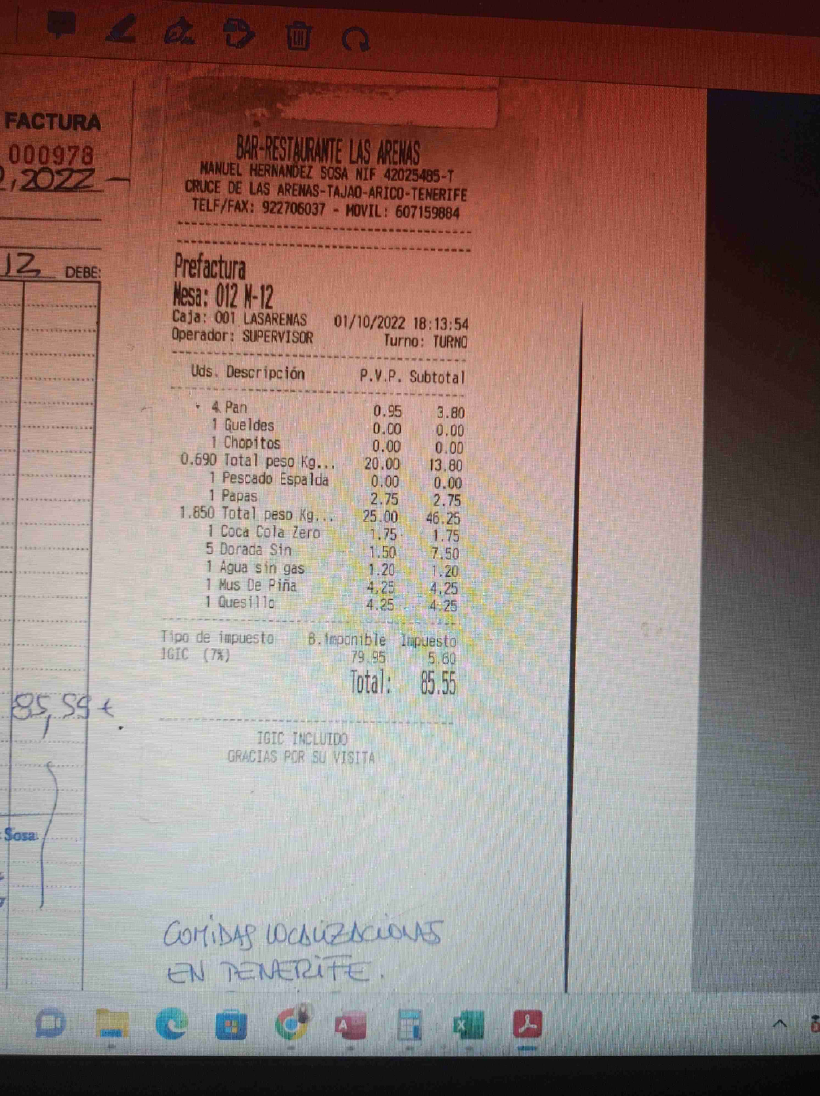

In [ ]:
show_fact(1)

#Pre-Processing

#### Functions for Pre-Processing

In [ ]:
# Convert to greyscale
def greyscale(image):
  greyscale = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  return greyscale

# Enhance contrast
def contrast(image):
  contrast_factor = 1.5 # Adjust this value to increase or decrease contrast
  contrast_enhancer = ImageEnhance.Contrast(Image.fromarray(image)) # convert to PIL image and enhance contrast
  enhanced_img = np.asarray(contrast_enhancer.enhance(contrast_factor)) # convert back to numpy array
  return enhanced_img

# Resizing image / Normalizing image
def resize(image, target_dpi):
    if isinstance(image, np.ndarray):
        # Convert array to Image object
        img = Image.fromarray(image)

    # Calculate the target size based on the current size and desired DPI
    w, h = img.size
    current_dpi = img.info.get('dpi', (72, 72))[0]
    scale_factor = target_dpi / current_dpi
    target_size = (int(w * scale_factor), int(h * scale_factor))

    # Resample the image to the target size and DPI
    resized_image = img.resize(target_size, resample=Image.BICUBIC)
    resized_image.info['dpi'] = (target_dpi, target_dpi)

    if isinstance(image, np.ndarray):
        # Convert Image object back to grayscale array
        resized_image = np.array(resized_image)
    # return np.uint8(resized_image)
    return resized_image

# Binarization after Gaussian filtering, Input must be greyscale, Binarisation nach https://docs.opencv.org/4.x/d7/d4d/tutorial_py_thresholding.html

def threshold(image):
    # Check if image is grayscale
    if len(image.shape) == 3 and image.shape[2] == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    elif len(image.shape) == 3 and image.shape[2] == 4:
        image = cv2.cvtColor(image, cv2.COLOR_BGRA2GRAY)

    # ret1, th1 = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY) # Global thresholding (performed worse on test receipt)
    ret2, th2 = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU) # Otsu's thresholding
    # blur = cv2.GaussianBlur(image, (5, 5), 0)
    # ret3, th3 = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU) # Otsu's thresholding after Gaussian filtering (performed worse on test receipt)
    return th2

# Removing shadows
def shadow(image):
    rgb_planes = cv2.split(image)
    result_norm_planes = []
    for plane in rgb_planes:
        dilated_img = cv2.dilate(plane, np.ones((7,7), np.uint8))
        bg_img = cv2.medianBlur(dilated_img, 21)
        diff_img = 255 - cv2.absdiff(plane, bg_img)
        norm_img = cv2.normalize(diff_img,None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
        result_norm_planes.append(norm_img)
    shadowremov = cv2.merge(result_norm_planes)
    return shadowremov

# Sharpening image with a kernel, https://www.analyticsvidhya.com/blog/2021/08/sharpening-an-image-using-opencv-library-in-python/
def sharpen(image):
  kernel = np.array([[0, -1, 0],
                   [-1, 5,-1],
                   [0, -1, 0]])
  image_sharp = cv2.filter2D(src=image, ddepth=-1, kernel=kernel)
  return image_sharp


# De-noising - Function 1
def denoise(image):
  #converted_img = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR) # denoising needs 3 channels, i.e. greyscale pictures would need to be converted
  dst = cv2.fastNlMeansDenoising(image, None, 10, 7, 15) 
  return dst

# De-noising - Function 2
def noise_removal(image):
  kernel = np.ones((1,1), np.uint8)
  image = cv2.dilate(image, kernel, iterations = 1)
  kernel = np.ones((1,1), np.uint8)
  image = cv2.erode(image, kernel, iterations = 1)
  image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
  image = cv2.medianBlur(image, 3)
  return image

# Rotation - Function 1
def rotate(image):

    angle = determine_skew(image)
    if angle is None:
        angle = 0
    background = (0, 0, 0)

    old_width, old_height = image.shape[:2]
    angle_radian = math.radians(angle)
    width = abs(np.sin(angle_radian) * old_height) + abs(np.cos(angle_radian) * old_width)
    height = abs(np.sin(angle_radian) * old_width) + abs(np.cos(angle_radian) * old_height)

    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    rot_mat[1, 2] += (width - old_width) / 2
    rot_mat[0, 2] += (height - old_height) / 2
    return cv2.warpAffine(image, rot_mat, (int(round(height)), int(round(width))), borderValue=background)

# Rotation - Function 2
def correct_skew(image):
    # Convert to grayscale
    grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Find contours and extract the largest one
    contours, _ = cv2.findContours(grayscale_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    largest_contour = max(contours, key=cv2.contourArea)

    # Find the minimum area rectangle that bounds the largest contour
    rect = cv2.minAreaRect(largest_contour)

    # Compute the angle of rotation
    angle = rect[-1]
    if angle < -45:
        angle += 90
    else:
        angle -= 90
        
    # Rotate the image to correct the skew
    if angle < -45:
        angle += 90
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated_image = cv2.warpAffine(image, rotation_matrix, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)

    return rotated_image

def thin_font(image):
  image = cv2.bitwise_not(image)
  kernel = np.ones((2,2), np.uint8)
  image = cv2.erode(image, kernel, iterations = 1)
  image = cv2.bitwise_not(image)
  return image 

def thick_font(image):
  image = cv2.bitwise_not(image)
  kernel = np.ones((2,2), np.uint8)
  image = cv2.dilate(image, kernel, iterations = 1)
  image = cv2.bitwise_not(image)
  return image 
  

#### Pre-Processing of all Facturas

In [ ]:
## Defined order of preprocessing steps
## Pre-processed all images in a for loop and saved preprocessed images in a list

preprocessed = []

for i in tqdm(range(len(fact_images))): # tqdm used to show progress of computation
  img = np.asarray(fact_images[i][0])
    
  resized = resize(img, 300)
  rotated = rotate(resized)
  contrasted = contrast(rotated)
  removed_shadow = shadow(contrasted)
  thresholded = threshold(removed_shadow) 
  sharpened = sharpen(thresholded) 
  denoised = noise_removal(sharpened) 
  thicked = thick_font(denoised)
  final = thicked
  preprocessed.append(final)

## Saving all images in a single .npy file
np.save("/content/drive/MyDrive/Pre-Processed/preprocessed_images.npy", preprocessed)

## 1st run:
## Preprocesing with pipeline: resized, skew_corrected_image, contrasted, removed_shadow, thresholded, sharpened took 11:06 mins (4.44/it)
## - No denoising, but with skew-correction
## - Not updated with Silvia's functions

## 2nd run:
## Testing Silvia's preprocessing pipeline
## resize, skew_corrected_image, contrasted, removed_shadow, thresholded, sharpened, denoised, thicked, thicked1
## took 10:45 min (4.31s/it)

## 3rd run:
## Final pipeline
## resized, rotated, contrasted, removed_shadow, thresholded, sharpened, denoised, thicked
## Different rotation function seems to take a long time
## took 33:51 min (13.55s/it)

100%|██████████| 150/150 [35:33<00:00, 14.23s/it]


#### Loading pre-processed images

In [ ]:
# Load images from .npy file
loaded_preprocessed_images_array = np.load("/content/drive/MyDrive/Pre-Processed/preprocessed_images.npy", allow_pickle=True)
preprocessed_loaded = list(loaded_preprocessed_images_array) # Convert the loaded NumPy array back into a list

In [ ]:
## Function to display preprocessed image in convenient format

def display_image(image, width=800):
    height = int(image.shape[0] / image.shape[1] * width)
    display_img = cv2.resize(image, (width, height))
    cv2_imshow(display_img)

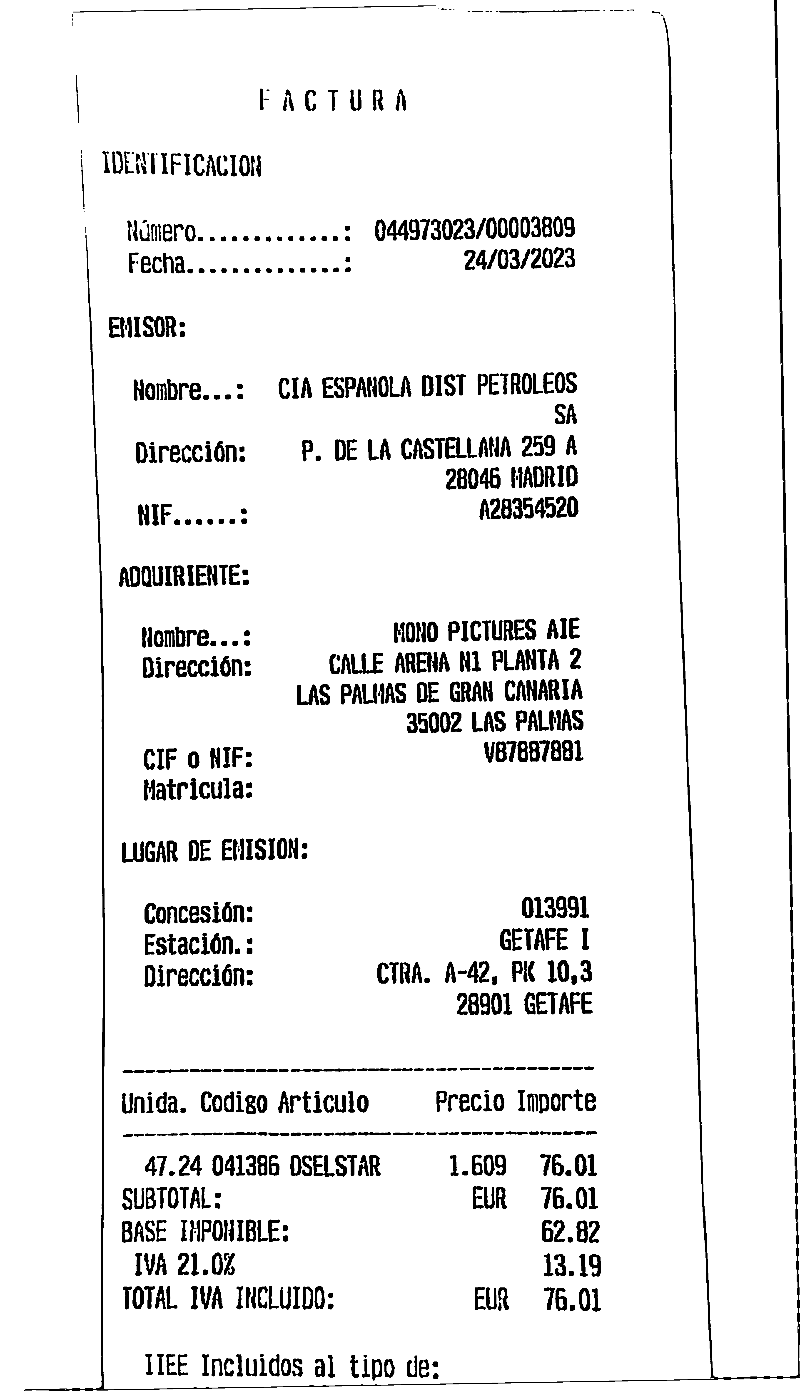

In [ ]:
display_image(preprocessed_loaded[6])

# Read text with OCR

#### All Facturas after Pre-Processing - Reading text via OCR

In [ ]:
## Language set to Spanish, Confidence level >= 10%, PSM 4

ocr_output = []

for image in tqdm(preprocessed_loaded):
  custom_config = '--psm 4' 
  df_1 = pytesseract.image_to_data(image, config=custom_config, lang='spa', output_type='data.frame')
  df_2 = df_1[df_1.conf >= 10] # only getting output with >= XY% confidence
  df = df_2.groupby(['block_num','line_num'])['text'].agg(lambda x: ' '.join(x.astype(str))).reset_index()
  text = ''
  for value in df['text']:
    text += value + '\n'
  
  ocr_output.append(text)


# Save OCR results
file_path = "/content/drive/MyDrive/OCR_Output/ocr_output.pkl"
with open(file_path, "wb") as f:
    pickle.dump(ocr_output, f)


## 1st OCR run took 17:30 mins to read text from the 150 Facturas, i.e. 7.01s/it on average
## 2nd OCR run took 15:11 mins, 6.08s/it on average
## 3rd OCR run took 20:35mins, 8.24s/it

100%|██████████| 150/150 [17:30<00:00,  7.00s/it]


In [ ]:
ocr_output[100]

" \nAmr ra YN\nA\nAtención al cilento\nDUPLICADO ABONO 022 621 632 AF-SA-TF.2023.002319\nSorvicio Post-Venta\n928 194 532\nFecha crerción: 07/03:2023 912 01\nMONO PICTURES CIF. CALLE ARENA 1 2 35002 - LAS PALMAS DE GRAN CANARIA, LAS PALMAS\nFACTURA: F-SA-TF-2023-015769 ABONO: A-SA-TF -2023-000014584 07/09/2023 12:01 KABOMBA LAMP PARED X3 REG LUM 1.00 53.00 $5.00 €\n3 DESCRIPCIÓN de PRECIO LETS\n   \n   \nOEA\nFecha de elaboración: 07/03/2023 Página 1 de 1\nSARTON CANAJTAS\nCommercial La Lega —C/ A IBTÍO\n'NSCRTA ON EL REGISTRO MERCANTIL CE El ENEL ASUNTO 408, DIARIO 106 FOLIO 109 DEL TOMO 1331 GAL. HOJA GC 1TIM E\nN ¡a\nW F\n161€ POR COMERCIANTE 222202000\n"

#### Loading OCR-Output

In [ ]:
# Load OCR results
file_path = "/content/drive/MyDrive/OCR_Output/ocr_output.pkl"
with open(file_path, "rb") as f:
    ocr_output_loaded = pickle.load(f)

In [ ]:
ocr_output_loaded[100]

" \nAmr ra YN\nA\nAtención al cilento\nDUPLICADO ABONO 022 621 632 AF-SA-TF.2023.002319\nSorvicio Post-Venta\n928 194 532\nFecha crerción: 07/03:2023 912 01\nMONO PICTURES CIF. CALLE ARENA 1 2 35002 - LAS PALMAS DE GRAN CANARIA, LAS PALMAS\nFACTURA: F-SA-TF-2023-015769 ABONO: A-SA-TF -2023-000014584 07/09/2023 12:01 KABOMBA LAMP PARED X3 REG LUM 1.00 53.00 $5.00 €\n3 DESCRIPCIÓN de PRECIO LETS\n   \n   \nOEA\nFecha de elaboración: 07/03/2023 Página 1 de 1\nSARTON CANAJTAS\nCommercial La Lega —C/ A IBTÍO\n'NSCRTA ON EL REGISTRO MERCANTIL CE El ENEL ASUNTO 408, DIARIO 106 FOLIO 109 DEL TOMO 1331 GAL. HOJA GC 1TIM E\nN ¡a\nW F\n161€ POR COMERCIANTE 222202000\n"

#### All Facturas without Pre-Processing - Reading text via OCR

In [ ]:
## Running OCR over all Facturas without having them preprocessed

ocr_output_no_prep = []

for fact in tqdm(fact_images):
  image = fact[0]
  custom_config = '--psm 4' 
  df_1 = pytesseract.image_to_data(image, config=custom_config, lang='spa', output_type='data.frame')
  df_2 = df_1[df_1.conf >= 10] # only getting output with >= XY% confidence
  df = df_2.groupby(['block_num','line_num'])['text'].agg(lambda x: ' '.join(x.astype(str))).reset_index()
  text = ''
  for value in df['text']:
    text += value + '\n'
  
  ocr_output_no_prep.append(text)

## Running OCR on images without pre-processing is faster
## Took 5:58 min in total, i.e. only 2.39s / it
## Possible reason might be resizing (more information to read via OCR)

100%|██████████| 150/150 [05:58<00:00,  2.39s/it]


# Post-Processing / Information extraction

#### All Facturas after Pre-Processing - Searching for Regex-Pattern

In [ ]:
## v17.04.

## For all Facturas
## Extract CIF and Invoice No. from all strings of ocr_output

cifs_detected = []
nos_detected = []

for text in ocr_output_loaded:
  string = text
  ## Extract CIF via RegEx
  # Keywords:  'N.I.F.', 'NIF', 'C.I.F.', 'CIF', 'DNI.'
  # re.search() and re.match() return only the first occurance of a substring in the string and ignore others (https://www.geeksforgeeks.org/python-re-search-vs-re-match/)
  pattern = r'(?:(N\.I\.F\.|NIF|C\.I\.F\.|CIF|CIF|DNI\.)(?:\s|:)*)(\S+)'
  match = re.search(pattern, string) 
  if match:
    cif_detected = match.group(2)
  else: 
    cif_detected = 'Not found'
  cifs_detected.append(cif_detected)

  ## Extract Invoice No. via RegEx
  # Keywords: 'No RECIBO', 'N.FACTURA', 'FACTURA', 'Numero', 'FACTURA No.', 'No.', 'Albarán', 'Factura'
  pattern = r'(?:(No RECIBO|N\.FACTURA|FACTURA|Factura|Numero|FACTURA No\.|No\.|Albarán|SIMPLIFICADA|Pagado)(?:\s|:)*)(\S+)'
  match = re.search(pattern, string)
  if match:
    no_detected = match.group(2)
  else: 
    no_detected = 'Not found'
  nos_detected.append(no_detected)


## v1: r'(N\.I\.F\.|NIF|C\.I\.F\.|CIF|CIF|DNI\.)..\s*(\S+)'
## v2: r'(N\.I\.F\.|NIF|C\.I\.F\.|CIF|CIF|DNI\.)\s*(\w{2})\W*(\S+)' ## terrible results
## v3: r'(?:(N\.I\.F\.|NIF|C\.I\.F\.|CIF|CIF|DNI\.)(?:\s|:)*)(\S+)' ## best results so far!!

## v1: r'(No RECIBO|N\.FACTURA|FACTURA|Factura|Numero|FACTURA No\.|No\.|Albarán)..\s*(\S+)'
## v2: r'(No RECIBO|N\.FACTURA|FACTURA|Factura|Numero|FACTURA No\.|No\.|Albarán)\s*(\w{2})\W*(\S+)' ## terrible results
## v3: r'(?:(No RECIBO|N\.FACTURA|FACTURA|Factura|Numero|FACTURA No\.|No\.|Albarán)(?:\s|:)*)(\S+)' ## best results so far!!

#### All Facturas without Pre-Processing - Searching for Regex-Pattern

In [ ]:
## For all Facturas, without pre-processing
## Extract CIF and Invoice No. from all strings of ocr_output

cifs_detected_no_prep = []
nos_detected_no_prep = []

for text in ocr_output_no_prep:
  string = text
  ## Extract CIF via RegEx
  # Keywords:  'N.I.F.', 'NIF', 'C.I.F.', 'CIF', 'DNI.'
  # re.search() and re.match() return only the first occurance of a substring in the string and ignore others (https://www.geeksforgeeks.org/python-re-search-vs-re-match/)
  pattern = r'(?:(N\.I\.F\.|NIF|C\.I\.F\.|CIF|CIF|DNI\.)(?:\s|:)*)(\S+)'
  match = re.search(pattern, string) 
  if match:
    cif_detected = match.group(2)
  else: 
    cif_detected = 'Not found'
  cifs_detected_no_prep.append(cif_detected)

  ## Extract Invoice No. via RegEx
  # Keywords: 'No RECIBO', 'N.FACTURA', 'FACTURA', 'Numero', 'FACTURA No.', 'No.', 'Albarán'
  pattern = r'(?:(No RECIBO|N\.FACTURA|FACTURA|Factura|Numero|FACTURA No\.|No\.|Albarán|SIMPLIFICADA|Pagado)(?:\s|:)*)(\S+)'
  match = re.search(pattern, string)
  if match:
    no_detected = match.group(2)
  else: 
    no_detected = 'Not found'
  nos_detected_no_prep.append(no_detected)

# Validation

#### All Facturas after Pre-Processing - Printing detected values

In [ ]:
print("CIF's:")
print(cifs_detected)
print("CIF retrieved in ",150-cifs_detected.count('Not found'),"cases")
print("CIF not found in ",cifs_detected.count('Not found'),"cases")
print("Invoice no.:")
print(nos_detected)
print("Invoice no. retrieved in ",150-nos_detected.count('Not found'),"cases")
print("Invoice no. not found in ",nos_detected.count('Not found'),"cases")

## 1st run with all Facturas and preprocessed images
# CIF's:
# ['Not found', 'Not found', 'Numero', 'Not found', 'Not found', 'Not found', 'NIF', 'Not found', 'Not found', 'SA28559573', 'ESA25999973', 'V87887881', 'ONO', 'Not found', 'Not found', 'V87887881', 'V87887881', 'NIF', 'Not found', 'Not found', 'Not found', 'Not found', 'IF', 'B7IJAT494', 'Not found', 'Not found', 'Not found', 'NIF', 'IF', 'Not found', '17418088', 'Not found', 'TEM', 'Not found', '862181409', 'Not found', 'SA28559573', 'Not found', 'Not found', 'Not found', 'Not found', 'B', 'NIF', 'Not found', 'ujeto', 'ujeto', 'ujeto', 'ujeto', 'Not found', 'IF', 'NIF', '850981057', 'E', 'IF', 'ujeto', 'B86054897', 'ESPAÑA', 'B', 'Not found', 'Not found', 'Not found', 'Not found', 'IF', 'Not found', 'Not found', 'Not found', 'Not found', 'B88058615', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'V87887881', 'B', 'A', 'Not found', 'Not found', '87887881', 'Not found', 'V87887881', 'Not found', 'V', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', '292', 'Not found', '87207486', 'B64774102', 'S', 'Not found', 'Not found', 'Not found', 'IF', 'Not found', 'VI7837881', 'V87887881', 'Not found', 'V87887881', 'Not found', 'Not found', 'Not found', 'Not found', '80', 'Not found', 'Not found', 'F', 'NIF', 'Not found', 'Not found', 'B72862642', 'IF', 'Not found', 'IF', 'ESA28559573', 'Not found', 'ACION', 'Not found', 'Not found', 'cálle', 'Not found', '88324090', '3', 'Not found', 'Not found', '0', 'Not found', 'IF', 'IF', '823709892', 'Not found', 'Not found', 'Not found', 'Not found', 'VA7387881', 'IF', 'B88324090', 'IF', 'A28425270', '88324090', 'Not found', 'NIF', 'B23709892', 'Not found', 'B23709892']
# CIF retrieved in  72 cases
# CIF not found in  78 cases
# Invoice no.:
# ['Not found', 'Not found', '39', 'e', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'onductor', 'Not found', 'Not found', 'TM051160', '000124', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'E', 'Not found', 'Not found', 'Not found', '17', 'Not found', 'Not found', 'Not found', 'el', 'Not found', 'Not found', 'Not found', '28', '04', 'Not found', 'Not found', 'IF', 'e', 'Not found', 'Not found', 'B831735629', '68633153', '68633153', 'actura', 'Not found', 'Not found', 'F230023', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'ECTIFICATIVA', 'Not found', 'O', '25', 'iF', 'IF', 'e', 'IF', 'IF', 'ECTIFICATIVA', 'e', '36', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'E', 'E', 'Not found', 'iF', 'Not found', 'Not found', 'Not found', 'Not found', 'F', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'IF', 'RDINARIA', 'IMPLIFICADA', 'IMPLIFICADA', '065', 'Not found', 'Not found', 'IF', 'actura', 'Not found', 'actura', 'Not found', 'Not found', '215425', 'Not found', 'Not found', 'IPLTELCAUA', 'ED', 'Not found', '59', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'actura', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'IMPLIFICADA', 'Not found', 'Not found', 'ÚMERO', 'Not found', 'LIENTE', 'Not found', 'Not found', 'NO', 'Not found', 'Not found']
# Invoice no. retrieved in  49 cases
# Invoice no. not found in  101 cases

## 2nd run (Silvia's pre-processing pipeline)
# CIF's:
# ['Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'NIF', 'Not found', 'Not found', 'ESA28559573', 'SA28559578', 'V87887881', 'Not found', 'Not found', 'B', 'V87887881', 'V87887881', 'NIF', 'Not found', 'Not found', 'Not found', 'Not found', '873347498', 'IF', 'Not found', 'Not found', 'Not found', 'NIF', 'IF', 'Not found', '17418088', 'Not found', 'TEN', 'Not found', 'BO2181409', 'Not found', 'SA28559573', 'Not found', 'Not found', 'Not found', 'Not found', 'B', 'NIF', 'Not found', 'ujeto', 'ujeto', 'ujeto', 'ujeto', 'Not found', 'IF', 'NIF', '860981057', 'V87887881', 'IF', 'ujeto', 'B86054897', 'V87887881', 'B', 'Not found', 'Not found', 'Not found', 'Not found', 'IF', 'Not found', 'Not found', 'Not found', 'Not found', 'B88058615', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', '8', 'A', 'Not found', 'Not found', 'V87887881', 'de', 'V87887', 'Not found', 'Numero', 'V87887881', 'A', 'Not found', 'Not found', 'Not found', '170968', 'Not found', '87207486', 'BS4774102', 'S', 'Not found', 'Not found', 'Not found', 'IF', 'Not found', 'VO7837881', 'V87887881', 'Not found', 'V87887881', 'Not found', 'BE092105', 'BE0931057', 'Not found', 'deas', 'Not found', 'Not found', 'F', 'NIF', 'Not found', '7492387', 'Not found', 'IF', 'Not found', 'IF', 'SA28559573', 'Not found', 'ACION', 'Not found', 'Not found', '137207486', 'Not found', '88324090', 'BO0S346176', 'Not found', 'Not found', 'Not found', 'Not found', 'EST', 'IF', 'B23709892', 'Not found', 'Not found', 'Not found', 'Not found', 'VB7387881', 'IF', 'B88324090', 'IF', 'A28425270', '88324090', 'NI', 'NIF', 'B237090892', '25166', '823709892']
# CIF retrieved in  76 cases
# CIF not found in  74 cases
# Invoice no.:
# ['Not found', 'Not found', '39', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', '9', 'Not found', 'Not found', 'TM05', '000124', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'E', 'Not found', 'Not found', 'Not found', '17', 'Not found', 'Not found', 'Not found', 'el', 'Not found', 'Not found', 'Not found', '28', '04', 'Not found', 'Not found', 'IF', 'Not found', 'Not found', 'Not found', 'B831735629', '564', '504', 'actura', 'Not found', 'Not found', 'F230023', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'F', 'Not found', '27', '25', 'iF', '50', 'IF', 'IF', 'Not found', 'IF', 'IF', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'E', 'Not found', 'Not found', '9', 'r', 'Not found', 'Not found', 'Not found', 'F', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'RDINARIA', 'IMPLIFICADA', 'Not found', 'Not found', 'Not found', 'Not found', 'IF', 'actura', 'Not found', 'actura', 'Not found', 'Not found', '215425', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'IF', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'actura', 'Not found', 'Not found', 'N', '70', 'Not found', 'IMPLIFICADA', 'Not found', 'l', 'ÚMERO', 'Not found', 'FACTURA', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found']
# Invoice no. retrieved in  42 cases
# Invoice no. not found in  108 cases

## 3rd run (Silvia's pipeline + added 'Factura' to RegEx)
# CIF's:
# ['Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'NIF', 'Not found', 'Not found', 'ESA28559573', 'SA28559578', 'V87887881', 'Not found', 'Not found', 'B', 'V87887881', 'V87887881', 'NIF', 'Not found', 'Not found', 'Not found', 'Not found', '873347498', 'IF', 'Not found', 'Not found', 'Not found', 'NIF', 'IF', 'Not found', '17418088', 'Not found', 'TEN', 'Not found', 'BO2181409', 'Not found', 'SA28559573', 'Not found', 'Not found', 'Not found', 'Not found', 'B', 'NIF', 'Not found', 'ujeto', 'ujeto', 'ujeto', 'ujeto', 'Not found', 'IF', 'NIF', '860981057', 'V87887881', 'IF', 'ujeto', 'B86054897', 'V87887881', 'B', 'Not found', 'Not found', 'Not found', 'Not found', 'IF', 'Not found', 'Not found', 'Not found', 'Not found', 'B88058615', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', '8', 'A', 'Not found', 'Not found', 'V87887881', 'de', 'V87887', 'Not found', 'Numero', 'V87887881', 'A', 'Not found', 'Not found', 'Not found', '170968', 'Not found', '87207486', 'BS4774102', 'S', 'Not found', 'Not found', 'Not found', 'IF', 'Not found', 'VO7837881', 'V87887881', 'Not found', 'V87887881', 'Not found', 'BE092105', 'BE0931057', 'Not found', 'deas', 'Not found', 'Not found', 'F', 'NIF', 'Not found', '7492387', 'Not found', 'IF', 'Not found', 'IF', 'SA28559573', 'Not found', 'ACION', 'Not found', 'Not found', '137207486', 'Not found', '88324090', 'BO0S346176', 'Not found', 'Not found', 'Not found', 'Not found', 'EST', 'IF', 'B23709892', 'Not found', 'Not found', 'Not found', 'Not found', 'VB7387881', 'IF', 'B88324090', 'IF', 'A28425270', '88324090', 'NI', 'NIF', 'B237090892', '25166', '823709892']
# CIF retrieved in  76 cases
# CIF not found in  74 cases
# Invoice no.:
# ['Not found', 'Not found', '39', 'Not found', 'Not found', 'P30003632', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', '0', 'Not found', '00210', 'Not found', 'erie', 'erie', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'e', 'Not found', '9', 'Not found', 'Not found', 'TM05', '000124', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'implificada', 'E', 'Not found', 'Not found', 'Not found', 'úmero', 'Not found', 'Not found', 'Not found', 'el', 'implificada', 'implificada', 'Not found', '28', '04', 'Not found', 'Not found', 'IF', 'Not found', 'Not found', 'Not found', 'B831735629', '564', '504', 'actura', 'Not found', 'Not found', 'F230023', 'Not found', 'A', 'Not found', 'h', 'l', 'Not found', 'l', 'Not found', 'Not found', 'F', 'Not found', '27', '25', 'iF', '50', 'IF', 'IF', 'Not found', 'IF', 'IF', 'Not found', 'n', 'Not found', 'Not found', 'ompleta', 'Factura', 't', 'Not found', 'on', '9', 'r', 'Not found', 'Fecha', '845', 'F', '3', 'Not found', '1', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'RDINARIA', 'IMPLIFICADA', 'Not found', 'Not found', 'Not found', 'Not found', 'IF', 'actura', 'Not found', 'actura', 'Not found', 'Not found', '215425', 'Not found', 'echa', 'Not found', 'de', 'Not found', 'IF', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'actura', 'Not found', 'Not found', 'N', '70', 'Not found', 'IMPLIFICADA', 'Not found', 'l', 'ÚMERO', 'Fecha', 'FACTURA', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found']
# Invoice no. retrieved in  66 cases
# Invoice no. not found in  84 cases

## 4th run (final Pipeline, 17.04., including 'Factura')
# CIF's:
# ['Not found', 'Not found', 'Not found', 'Not found', '082900576', 'Not found', 'v87887881', 'Not found', 'Not found', 'Not found', 'Not found', 'V87887881', 'Not found', 'Not found', 'Not found', 'V87887881', 'V87887881', 'va7887881', 'Not found', 'Not found', 'Not found', 'Not found', '7347498', 'B73I347494', 'Not found', 'Not found', 'Not found', 'Ult', 'IF', 'Not found', '17418088', 'Not found', 'TIM', 'Not found', 'Descuyet', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'B', 'RIE', 'Not found', 'ujeto', 'ujeto', 'ujeto', 'ujeto', 'Not found', 'IF', 'NIF', 'Not found', 'Not found', 'NIF', 'ujeto', 'B86054897', 'V878897881', 'B', 'Not found', 'Not found', 'Not found', 'Not found', 'IF', 'Not found', 'Not found', 'Not found', 'Not found', 'B88058615', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'B', 'A', 'Not found', 'Not found', 'V87887881', 'Not found', 'V87887881', 'a', 'v', 'Not found', 'A', 'Not found', 'Domiciia', 'Not found', '292', 'Not found', 'B7207486', 'Not found', 'S', 'DO9816099', 'Not found', 'Not found', 'IF', 'Not found', 'CALLE', 'V87887881', 'Not found', 'V87887881', 'Not found', 'Not found', 'Not found', 'Not found', 'deas', 'Not found', 'Not found', 'F', 'NIF', 'Not found', '0749238', 'pa', 'IF', 'Not found', 'IF', 'ESA283199973', '03102', 'Not found', 'B', 'Not found', 'v87207906', 'VBT2DSIEB', '88324090', 'B0S346176', 'Not found', 'Not found', '033854091', 'Not found', 'MIF', 'IF', 'B23709892', 'Not found', 'Not found', 'Not found', 'Not found', 'VB7387881', 'IF', 'B88324090', 'IF', 'A28425270', '88324090', 'Not found', 'NIF', 'B23709892', 'Not found', '823709892']
# CIF retrieved in  71 cases
# CIF not found in  79 cases
# Invoice no.:
# ['Not found', 'Not found', '39', 'e', 'aó', 'P30003632', 'Not found', 'Not found', 'echo', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'erie', 'erie', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'e', 'Not found', 'avos', 'Not found', 'Not found', 'TM051160', '000124', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'implificada', 'E', 'Not found', 'Not found', 'Not found', 'úmero', 'Not found', 'Not found', 'Not found', 'Not found', 'implificada', 'implificada', 'Not found', 'Not found', '04', 'Not found', 'Not found', 'IF', 'e', 'ds', 'Not found', 'B831735629', '564', '504', 'actura', 'j', 'Not found', 'F230023', 'Not found', 'A', 'Not found', 'e', 'Not found', 'Not found', 'l', 'Not found', 'Not found', 'i', 'Not found', '27', '25', 'iF', 'IF', 'e', 'IF', 'IF', 'ECTIFICATIVA', 'Not found', '27', 'mn', 'Not found', 'Not found', 'ompleta', 'Factura', 'T2023', 'l', 'on', '9', 'Not found', 'Not found', 'actura', 'F', 'F', '3', 'Not found', '1', 'Not found', 'Not found', 'Not found', 'Not found', 'iF', 'RDINARIA', 'IMPLIFICADA', 'IMPLIFICADA', 'Not found', 'Not found', 'Not found', 'IF', 'actura', 'Not found', 'actura', 'Not found', 'on', '215425', 'Not found', 'echa', 'Not found', 'Not found', 'Not found', '59', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'actura', 'Not found', 'Not found', 'Not found', 'a', 'Not found', 'IMPLIFICADA', 'Not found', 'Centro', 'ÚMERO', 'Focha', 'FACTURA', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found']
# Invoice no. retrieved in  69 cases
# Invoice no. not found in  81 cases

## 5th run (17.04. with S+)
# CIF's:
# ['Not found', 'Not found', 'Not found', 'Not found', '082900576', 'Not found', 'v87887881', 'Not found', 'Not found', 'Not found', 'Not found', 'V87887881', 'Not found', 'Not found', '-88580329', 'V87887881', 'V87887881', 'va7887881', 'Not found', 'Not found', 'Not found', 'Not found', '7347498', 'B73I347494', 'Not found', 'Not found', 'Not found', '....', 'IF:', '-88580329', '17418088', 'Not found', 'TIM:', 'Not found', 'Descuyet', 'Not found', 'Not found', 'Not found', 'Not found', '(ES)A84330133', 'Not found', 'B-81089047', 'RIE:', 'Not found', 'ujeto', 'ujeto', 'ujeto', 'ujeto', 'Not found', 'IF.', '.....', 'Not found', 'Not found', 'NIF:', 'ujeto', 'B86054897', 'V878897881', 'B-82819608', 'Not found', 'Not found', 'Not found', 'Not found', 'IF:', 'Not found', 'Not found', 'Not found', 'Not found', 'B88058615', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', '/28081832', 'Not found', 'Not found', 'B-87110631', 'A-79209854', 'Not found', 'Not found', 'V87887881', 'Not found', 'V87887881', 'a', 'v', '—', 'A:78208854', 'Not found', 'Domiciia.', 'Not found', '292', 'Not found', 'B7207486', 'Not found', 'S', 'DO9816099', 'Not found', 'Not found', 'IF:', 'Not found', 'CALLE', 'V87887881', 'Not found', 'V87887881', 'Not found', 'Not found', 'Not found', 'Not found', 'deas', 'Not found', 'Not found', 'F-20033361', 'NIF:', 'Not found', '0749238', 'pa', 'IF:', 'Not found', 'IF:', 'ESA283199973', '03102', 'Not found', 'B-40165995', 'Not found', 'v87207906', 'VBT2DSIEB', '/NIF:B88324090', 'B0S346176', 'Not found', 'Not found', '033854091', 'Not found', 'MIF:', 'IF:', 'B23709892', 'Not found', 'Not found', 'Not found', 'Not found', 'VB7387881', 'IF:', 'B88324090', 'IF:', 'A28425270', '88324090', 'Not found', 'NIF:', 'B23709892', 'Not found', '823709892']
# CIF retrieved in  76 cases
# CIF not found in  74 cases
# Invoice no.:
# ['Not found', 'Not found', '39-0003-1', 'e', 'aó', 'P30003632', 'Not found', 'Not found', 'echo', 'Not found', 'Not found', '%:', '*', 'Not found', 'Not found', 'erie', 'erie', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'e', 'Not found', 'avos', 'Not found', 'Not found', 'TM051160', '000124', 'Not found', 'Not found', 'Not found', '*', 'Not found', 'Not found', 'Not found', 'implificada', 'E', 'Not found', 'Not found', 'Not found', 'úmero:', 'Not found', 'Not found', 'Not found', 'Not found', 'implificada', 'implificada:', 'Not found', 'Not found', '04-0003-890266', 'Not found', 'Not found', 'IF', 'e', 'ds.', 'Not found', 'B831735629', '564', '504', 'actura:', 'j', 'Not found', 'F230023', 'Not found', 'A-V2023-00001229390', 'Not found', 'e', 'Not found', 'Not found', 'l.', 'Not found', 'Not found', 'i', 'Not found', '27-03-2003', '25-0003-054485', 'iF', 'IF', 'e', 'IF', 'IF', 'ECTIFICATIVA', 'Not found', '27-03-2005', 'mn”', 'Not found', "'*", 'ompleta', 'Factura', ':', 'l', 'on', '9', 'Not found', '.', 'actura:', 'F', 'F-SA-TF-2023-015769', '%:', 'Not found', '%:', 'Not found', 'Not found', 'Not found', 'Not found', 'iF', 'RDINARIA', 'IMPLIFICADA', 'IMPLIFICADA', 'Not found', 'Not found', 'Not found', 'IF', 'actura:', 'Not found', 'actura:', 'Not found', 'on', '215425', 'Not found', 'echa', 'Not found', 'Not found', 'Not found', '59-0003-171625', 'Not found', 'Not found', '*.', 'Not found', 'Not found', 'actura:', 'Not found', '?:', '|', 'a', 'Not found', 'IMPLIFICADA:', 'Not found', 'Centro:', 'ÚMERO:', 'Focha', 'FACTURA', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found']
# Invoice no. retrieved in  77 cases
# # Invoice no. not found in  73 cases

##6th run GPT4
# CIF's:
# ['Not found', 'Not found', 'Not found', 'Not found', '082900576', 'Not found', 'v87887881', 'Not found', 'Not found', 'Not found', 'Not found', 'V87887881', 'Not found', 'Not found', 'B-88580329', 'V87887881', 'V87887881', 'va7887881', 'Not found', 'Not found', 'Not found', 'Not found', '87347498', '.', 'Not found', 'Not found', 'Not found', '......', '/NIF:', 'B-88580329', 'B17418088', 'Not found', 'TIM:', 'Not found', 'Descuyet', 'Not found', 'Not found', 'Not found', 'Not found', '(ES)A84330133', 'Not found', 'B-81089047', 'O', 'Not found', 'sujeto', 'sujeto', 'sujeto', 'sujeto', 'Not found', '/NIF.', '.', 'Not found', 'Not found', '/NIF:', 'sujeto', 'B86054897', 'V878897881', 'B-82819608', 'Not found', 'Not found', 'Not found', 'Not found', '/CIF:', 'Not found', 'Not found', 'Not found', 'Not found', 'B88058615', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'A/28081832', 'Not found', '=', 'B-87110631', 'A-79209854', 'Numero', 'Not found', 'V87887881', "'umero", 'V87887881', '.', '-v', '—', 'A:78208854', 'Not found', 'Domiciia.', 'Not found', '1', 'Not found', 'VB7207486', 'Not found', 'ES', '-', 'Not found', 'Not found', '/CIF:', 'Not found', '.', 'V87887881', 'Not found', 'V87887881', 'Not found', 'Not found', ':', 'Not found', 'ideas', 'Not found', 'Not found', 'F-20033361', 'o', 'Not found', '0749238', 'pa', '/CIF:', 'Not found', '/CIF:', 'ESA283199973', '03102', 'Not found', 'B-40165995', 'Not found', 'v87207906', 'VBT2DSIEB', '/NIF:B88324090', 'B0S346176', 'Not found', 'Not found', '033854091', 'Not found', 'o', '/CIF:', 'B23709892', 'Not found', 'Not found', 'Not found', 'Not found', 'VB7387881', '/CIF:', 'B88324090', '/CIF:', 'A28425270', 'B88324090', 'Not found', 'o', 'B23709892', 'Not found', '823709892']
# CIF retrieved in  80 cases
# CIF not found in  70 cases
# Invoice no.:
# ['Not found', 'Not found', '039-0003-1', 'de', 'faó', 'BP30003632', 'Not found', 'FE', '¿echo', 'FE', 'FE', 'N%:', 'N*', 'Not found', 'Not found', 'Serie', 'Serie', 'IDENTIFICACIÓN', 'Not found', 'Not found', 'Not found', 'Not found', 'ramos]', 'or]', 'de', 'Not found', 'Davos', 'Not found', 'Not found', 'TM051160', '000124', 'Not found', 'Not found', 'Not found', 'n*', 'Not found', 'FE', 'Not found', 'Simplificada', 'DE', 'Not found', 'Not found', 'Not found', 'Número:', 'Pagado', 'Pagado', 'Pagado', 'Pagado', 'Simplificada', 'Simplificada:', '-', 'Not found', '004-0003-890266', 'Not found', 'Pagado', 'ORIGINAL', 'de', 'Uds.', 'Not found', 'GB831735629', '564', '504', 'Factura:', 'aj', 'Not found', '£F230023', 'Not found', 'A-V2023-00001229390', 'Not found', 'de', 'Not found', 'Not found', 'nl.', 'Not found', 'Not found', 'Ni', 'Not found', '27-03-2003', '025-0003-054485', 'NiF', 'NIF', 'de', 'NIF', 'NIF', 'RECTIFICATIVA', 'Not found', '27-03-2005', 'mn”', 'Not found', "N'*", 'E', 'N', 'a', 'Ol', 'con', '09', 'Not found', 'W.', 'Factura:', 'CF', 'F-SA-TF-2023-015769', 'N%:', 'Not found', 'N%:', 'Not found', 'Not found', 'Not found', 'Not found', 'NiF', 'ORDINARIA', 'SIMPLIFICADA', 'SIMPLIFICADA', 'Not found', 'Not found', 'Not found', 'NIF', 'Factura:', 'Not found', 'Factura:', 'Not found', 'tion', '215425', 'Not found', 'IM', 'Not found', 'Not found', 'Adquiriente', '259-0003-171625', 'Not found', 'Not found', 'N*.', 'Not found', 'Not found', 'Factura:', 'Not found', 'N?:', '|', 'a', 'Not found', 'SIMPLIFICADA:', 'Not found', 'Centro:', 'MÚMERO:', 'Carrefour', 'C', 'Not found', 'Not found', 'N%:', 'Not found', 'Not found']
# Invoice no. retrieved in  92 cases
# Invoice no. not found in  58 cases

##7th
# CIF's:
# ['Not found', 'Not found', 'Not found', 'Not found', '082900576', 'Not found', 'v87887881', 'Not found', 'Not found', 'Not found', 'Not found', 'V87887881', 'Not found', 'Not found', 'B-88580329', 'V87887881', 'V87887881', 'va7887881', 'Not found', 'Not found', 'Not found', 'Not found', '87347498', '.', 'Not found', 'Not found', 'Not found', '......', '/NIF:', 'B-88580329', 'B17418088', 'Not found', 'TIM:', 'Not found', 'Descuyet', 'Not found', 'Not found', 'Not found', 'Not found', '(ES)A84330133', 'Not found', 'B-81089047', 'O', 'Not found', 'sujeto', 'sujeto', 'sujeto', 'sujeto', 'Not found', '/NIF.', '.', 'Not found', 'Not found', '/NIF:', 'sujeto', 'B86054897', 'V878897881', 'B-82819608', 'Not found', 'Not found', 'Not found', 'Not found', '/CIF:', 'Not found', 'Not found', 'Not found', 'Not found', 'B88058615', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'A/28081832', 'Not found', '=', 'B-87110631', 'A-79209854', 'Numero', 'Not found', 'V87887881', "'umero", 'V87887881', '.', '-v', '—', 'A:78208854', 'Not found', 'Domiciia.', 'Not found', '1', 'Not found', 'VB7207486', 'Not found', 'ES', '-', 'Not found', 'Not found', '/CIF:', 'Not found', '.', 'V87887881', 'Not found', 'V87887881', 'Not found', 'Not found', ':', 'Not found', 'ideas', 'Not found', 'Not found', 'F-20033361', 'o', 'Not found', '0749238', 'pa', '/CIF:', 'Not found', '/CIF:', 'ESA283199973', '03102', 'Not found', 'B-40165995', 'Not found', 'v87207906', 'VBT2DSIEB', '/NIF:B88324090', 'B0S346176', 'Not found', 'Not found', '033854091', 'Not found', 'o', '/CIF:', 'B23709892', 'Not found', 'Not found', 'Not found', 'Not found', 'VB7387881', '/CIF:', 'B88324090', '/CIF:', 'A28425270', 'B88324090', 'Not found', 'o', 'B23709892', 'Not found', '823709892']
# CIF retrieved in  80 cases
# CIF not found in  70 cases
# Invoice no.:
# ['Not found', 'Not found', '039-0003-1', 'de', 'faó', 'BP30003632', 'Not found', 'FE', '¿echo', 'FE', 'FE', 'N%:', 'N*', 'Not found', 'Not found', 'Serie', 'Serie', 'IDENTIFICACIÓN', 'Not found', 'Not found', 'Not found', 'Not found', 'ramos]', 'or]', 'de', 'Not found', 'Davos', 'Not found', 'Not found', 'TM051160', '000124', 'Not found', 'Not found', 'Not found', 'n*', 'Not found', 'FE', 'Not found', 'Simplificada', 'DE', 'Not found', '135,01', 'Not found', 'Número:', 'Pagado', 'Pagado', 'Pagado', 'Pagado', 'Simplificada', 'Simplificada:', '-', 'Not found', '004-0003-890266', 'Not found', 'Pagado', 'ORIGINAL', 'de', 'Uds.', 'Not found', 'GB831735629', '564', '504', 'Factura:', 'aj', 'Not found', '£F230023', 'Not found', 'A-V2023-00001229390', 'Not found', 'de', 'Not found', 'Not found', 'nl.', 'Not found', 'Not found', 'Ni', 'Not found', '27-03-2003', '025-0003-054485', 'NiF', 'NIF', 'de', 'NIF', 'NIF', 'RECTIFICATIVA', 'Not found', '27-03-2005', 'mn”', 'Not found', "N'*", 'E', 'N', 'a', 'Ol', 'con', '09', 'Not found', 'W.', 'Factura:', 'CF', 'F-SA-TF-2023-015769', 'N%:', 'Not found', 'N%:', 'Not found', 'Not found', 'Not found', 'Not found', 'NiF', 'ORDINARIA', 'SIMPLIFICADA', 'SIMPLIFICADA', 'Not found', 'Not found', 'Not found', 'NIF', 'Factura:', 'Not found', 'Factura:', 'Not found', 'tion', '215425', 'Not found', 'IM', 'Not found', 'Not found', 'Adquiriente', '259-0003-171625', 'Not found', 'Not found', 'N*.', 'Not found', 'Not found', 'Factura:', 'Not found', 'N?:', '|', 'a', 'Not found', 'SIMPLIFICADA:', 'Not found', 'Centro:', 'MÚMERO:', 'Carrefour', 'C', 'Not found', 'Not found', 'N%:', 'Not found', 'Not found']
# Invoice no. retrieved in  93 cases
# Invoice no. not found in  57 cases

CIF's:
['Not found', 'Not found', 'Not found', 'Not found', '082900576', 'Not found', 'v87887881', 'Not found', 'Not found', 'Not found', 'Not found', 'V87887881', 'Not found', 'Not found', 'B-88580329', 'V87887881', 'V87887881', 'va7887881', 'Not found', 'Not found', 'Not found', 'Not found', '87347498', '.', 'Not found', 'Not found', 'Not found', '......', '/NIF:', 'B-88580329', 'B17418088', 'Not found', 'TIM:', 'Not found', 'Descuyet', 'Not found', 'Not found', 'Not found', 'Not found', '(ES)A84330133', 'Not found', 'B-81089047', 'O', 'Not found', 'sujeto', 'sujeto', 'sujeto', 'sujeto', 'Not found', '/NIF.', '.', 'Not found', 'Not found', '/NIF:', 'sujeto', 'B86054897', 'V878897881', 'B-82819608', 'Not found', 'Not found', 'Not found', 'Not found', '/CIF:', 'Not found', 'Not found', 'Not found', 'Not found', 'B88058615', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'A/28081832', 'Not found', '=', 'B-87110631', 'A-79209854', 'Numero', 'Not found', 'V87887881', "'u

#### All Facturas without Pre-Processing - Printing detected values

In [ ]:
print("CIF's:")
print(cifs_detected_no_prep)
print("CIF retrieved in ",150-cifs_detected_no_prep.count('Not found'),"cases")
print("CIF not found in ",cifs_detected_no_prep.count('Not found'),"cases")
print("Invoice no.:")
print(nos_detected_no_prep)
print("Invoice no. retrieved in ",150-nos_detected_no_prep.count('Not found'),"cases")
print("Invoice no. not found in ",nos_detected_no_prep.count('Not found'),"cases")

## 1st run with all Facturas without preprocessing images
# CIF's:
# ['Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'NIF', 'SA28359573', 'IF', 'SA28559573', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'V87887881', 'V87887881', 'NIF', 'Not found', 'Not found', 'Not found', 'Not found', 'IF', 'IF', 'Not found', 'Not found', 'Not found', 'NIF', 'IF', 'Not found', '17418088', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'SA28559573', 'Not found', 'Not found', 'Not found', 'Not found', 'B', 'NIF', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'IF', 'NIF', 'Not found', 'Not found', 'IF', 'Not found', 'Not found', 'Not found', 'B', 'Not found', 'Not found', 'Not found', 'Not found', 'IF', 'Not found', 'Not found', 'Not found', 'Not found', 'B88058615', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'B', 'A', 'UA', '87887881', 'Not found', '2', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', '817090001', 'Not found', '87207486', 'Inscrita', 'S', 'Not found', 'Not found', 'Not found', 'IF', 'Not found', 'Not found', 'VS7887881', 'Not found', 'Not found', 'A28925270', 'B609', 'B609', 'Not found', 'orn', 'Not found', 'Not found', 'F', 'NIF', 'Not found', 'Not found', 'Ba4406289', 'IF', 'Not found', 'IF', 'Not found', 'Not found', 'Not found', 'Not found', 'IF', 'Not found', 'Not found', '78492762', 'Not found', '87', 'Not found', 'Not found', 'Not found', 'NIF', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'IF', 'B88324090', 'Not found', 'Not found', 'B8324090', 'NIF', 'Not found', '823709892', 'Not found', 'B23709892']
# CIF retrieved in  51 cases
# CIF not found in  99 cases
# Invoice no.:
# ['Not found', 'Not found', '39', 'e', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', '0320100158064A0', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'TMO51160', '000124', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'E', 'Not found', 'Not found', 'Not found', 'NO00696', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', '04', 'Not found', 'Not found', 'IF', 'Not found', 'Not found', 'Not found', '01205', '409420332', 'Not found', 'actura', 'Not found', 'Not found', 'F230023', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', '25', 'IF', 'Not found', 'IF', 'e', 'Not found', 'e', 'Not found', '1', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'E', 'Not found', 'Not found', 'Not found', '14', 'Not found', 'actura', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', '21', 'Not found', 'Not found', 'RDINARIA', 'IMPLIFICADA', 'IMPLIFICADA', 'Not found', 'Not found', 'Not found', 'IF', 'actura', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'IMPLIFICADA', 'Not found', 'Not found', '59', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found', 'FACTURA', 'Not found', 'Not found', 'IMPLIFICADA', 'Not found', 'Not found', 'UROS', 'Not found', 'l', 'Not found', 'Not found', 'Not found', 'Not found', 'Not found']
# Invoice no. retrieved in  34 cases
# Invoice no. not found in  116 cases

CIF's:


NameError: ignored

#### All Facturas after Pre-Processing - Validating detected values

In [ ]:
## For all Facturas

# Getting labels for all facturas in same order as files loaded
# Comparing each label with output from information extraction
# Counting correct matches for CIF no's
# Counting correct matches for Invoice no's

cifs = []  
cif_validation = []

docs = []
doc_validation = []

for i in range(len(fact_images)):

  cif = fact_labels.loc[fact_labels['expense_id'] == fact_expense_ids[i],'supplier_cif'].values[0] # Labels from csv are in different order than in GDrive -> I searching the labels dataframe via the expense ID (from drive)
  cifs.append(cif) # putting the cifs (labels) into a list -> now in same order than loaded image files from drive

  cif_check = cif == cifs_detected[i] # comparing label with deteced cif
  cif_validation.append(cif_check)
  
  document_no = fact_labels.loc[fact_labels['expense_id'] == fact_expense_ids[i],'supplier_document_number'].values[0]
  docs.append(document_no)

  doc_check = document_no == nos_detected[i]
  doc_validation.append(doc_check)


print(cif_validation)
print(doc_validation)
print("Correct cif's: ",cif_validation.count(True))
print("Correct cif's: ",cif_validation.count(True)/len(cif_validation)*100, "%")
print("Correct document no's: ",doc_validation.count(True))
print("Correct document no's: ",doc_validation.count(True)/len(doc_validation)*100,"%")


## 1st run with all Facturas and preprocessed images
## 4/150 Cif's detected correctly (label matches extracted value)
## 2/150 Invoice document no's detected correctly (label matches extracted value)
# [False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, True, False, True]
# [False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]
# Correct cif's:  4
# Correct cif's:  2.666666666666667 %
# Correct document no's:  2
# Correct document no's:  1.3333333333333335 %

## 2nd run (Silvia's pre-processing pipeline)
# [False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False]
# [False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]
# Correct cif's:  2
# Correct cif's:  1.3333333333333335 %
# Correct document no's:  1
# Correct document no's:  0.6666666666666667 %

## 3rd run (final pipeline)
# [False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, True, False, False, False, True, False, False]
# [False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]
# Correct cif's:  3
# Correct cif's:  2.0 %
# Correct document no's:  2
# Correct document no's:  1.3333333333333335 %

## GPT4
# [False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, True, False, False, False, True, False, False]
# [False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]
# Correct cif's:  4
# Correct cif's:  2.666666666666667 %
# Correct document no's:  7
# Correct document no's:  4.666666666666667 %


[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, 

#### All Facturas without Pre-Processing - Validating detected values

In [ ]:
## For all Facturas without pre-processing

# Getting labels for all facturas in same order as files loaded
# Comparing each label with output from information extraction
# Counting correct matches for CIF no's
# Counting correct matches for Invoice no's

cifs = []  
cif_validation = []

docs = []
doc_validation = []

for i in range(len(fact_images)):

  cif = fact_labels.loc[fact_labels['expense_id'] == fact_expense_ids[i],'supplier_cif'].values[0] # Labels from csv are in different order than in GDrive -> I searching the labels dataframe via the expense ID (from drive)
  cifs.append(cif) # putting the cifs (labels) into a list -> now in same order than loaded image files from drive

  cif_check = cif == cifs_detected_no_prep[i] # comparing label with deteced cif
  cif_validation.append(cif_check)
  
  document_no = fact_labels.loc[fact_labels['expense_id'] == fact_expense_ids[i],'supplier_document_number'].values[0]
  docs.append(document_no)

  doc_check = document_no == nos_detected_no_prep[i]
  doc_validation.append(doc_check)


print(cif_validation)
print(doc_validation)
print("Correct cif's: ",cif_validation.count(True))
print("Correct cif's: ",cif_validation.count(True)/len(cif_validation)*100, "%")
print("Correct document no's: ",doc_validation.count(True))
print("Correct document no's: ",doc_validation.count(True)/len(doc_validation)*100,"%")


## Results without pre-processing
# [False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True]
# [False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]
# Correct cif's:  1
# Correct cif's:  0.6666666666666667 %
# Correct document no's:  0
# Correct document no's:  0.0 %

[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False

###Validating OCR output

In [ ]:
def count_labels_in_ocr(ocr_output_loaded, labels):
    if len(ocr_output_loaded) != len(labels):
        raise ValueError("Both lists must have the same length.")

    count = 0
    for ocr_output, label in zip(ocr_output_loaded, labels):
        count += ocr_output.count(label)
    return count

In [ ]:
result_1 = count_labels_in_ocr(ocr_output_loaded, cifs)
print(f"CIFs found {result_1} times in the OCR outputs.")

result_2 = count_labels_in_ocr(ocr_output_loaded, docs)
print(f"Invoice no. found {result_2} times in the OCR outputs.")

CIFs found 15 times in the OCR outputs.
Invoice no. found 46 times in the OCR outputs.


#### Inspecting results


In [ ]:
def inspect(no):
  print("cifs_detected: ", cifs_detected[no])
  print("nos_detected: ", nos_detected[no])
  print("OCR-Output: ", ocr_output_loaded[no])
  print(display_image(preprocessed_loaded[no]))
  return show_fact(no)

cifs_detected:  v87887881
nos_detected:  Not found
OCR-Output:  A O OI re
PACTURA
 IDENTIFICACION
..oooomonoo. -  044973023/00003809
24/03/2023
EMISOR:
Nombre...: CIA ESPANOLA DIST PETROLEOS
SA
Dirección: P. DE LA CASTELLANA 259 Á
28046 MADRID
NlF...... : A28354520
ADQUIRIENTE:
Hombre...: MONO PICTURES AJE
Dirección: CALLE ARENA N1 PLANTA 2
LAS PALMAS DE GRAN CANARIA
35002 LAS PALMAS
GIF O NIF: v87887881
Matricula:
LUGAR DE ENISION:
Concesión: 013991
Estación. : GETAFE 1
Dirección: CTRA. A-42, PIC 10,3
28901 GETAFE
DO APA A AAPP PA
GA APA ADE e ao A a A A A AU A E A A A A A A E A
Unida. Codigo Articulo Precio Importe
a A a o A AO A E A A ADA A O ADA AAA Ar a > de de a A DA A DO A A A A
41.24 041385 DSELSTAR 1.609 76.01
SUBTOTAL : EUR 76.01 IVA 21.02 13.19
BASE IMPONIBLE: 62.82 TOTAL IVA INCLUIDO: EUR 76.01
[TEE Incluidos al tipo de:



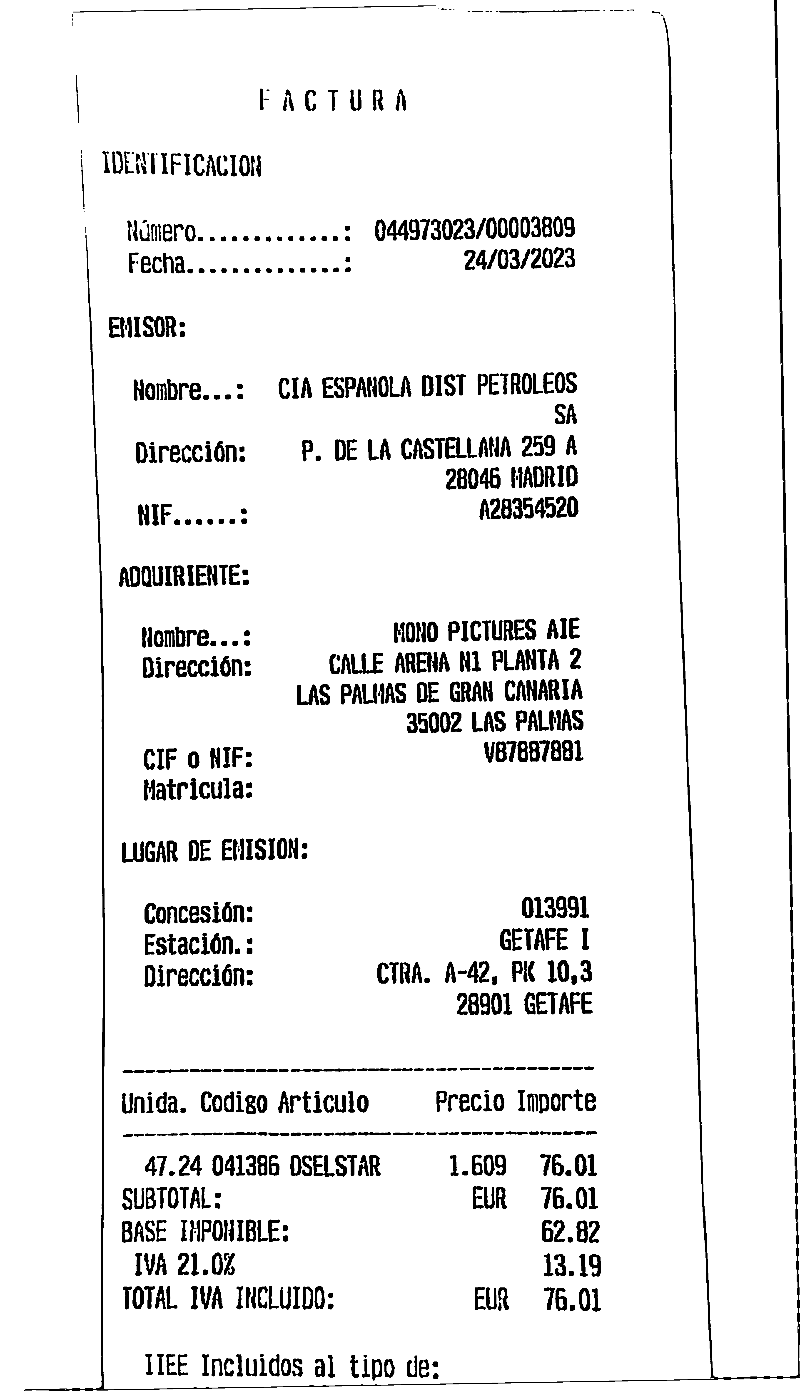

None
ae9ddd4e-730f-49cf-a0fd-2077b8ceb393
|    | company_id                           | expense_id                           |   supplier_document_number | supplier_cif                             |
|---:|:-------------------------------------|:-------------------------------------|---------------------------:|:-----------------------------------------|
|  6 | 67f1816f-f2bc-4079-9e4f-c0c9d81a27fb | ae9ddd4e-730f-49cf-a0fd-2077b8ceb393 |                       3809 | A28354520 CIA ESPANOLA DIST PETROLEOS SA |


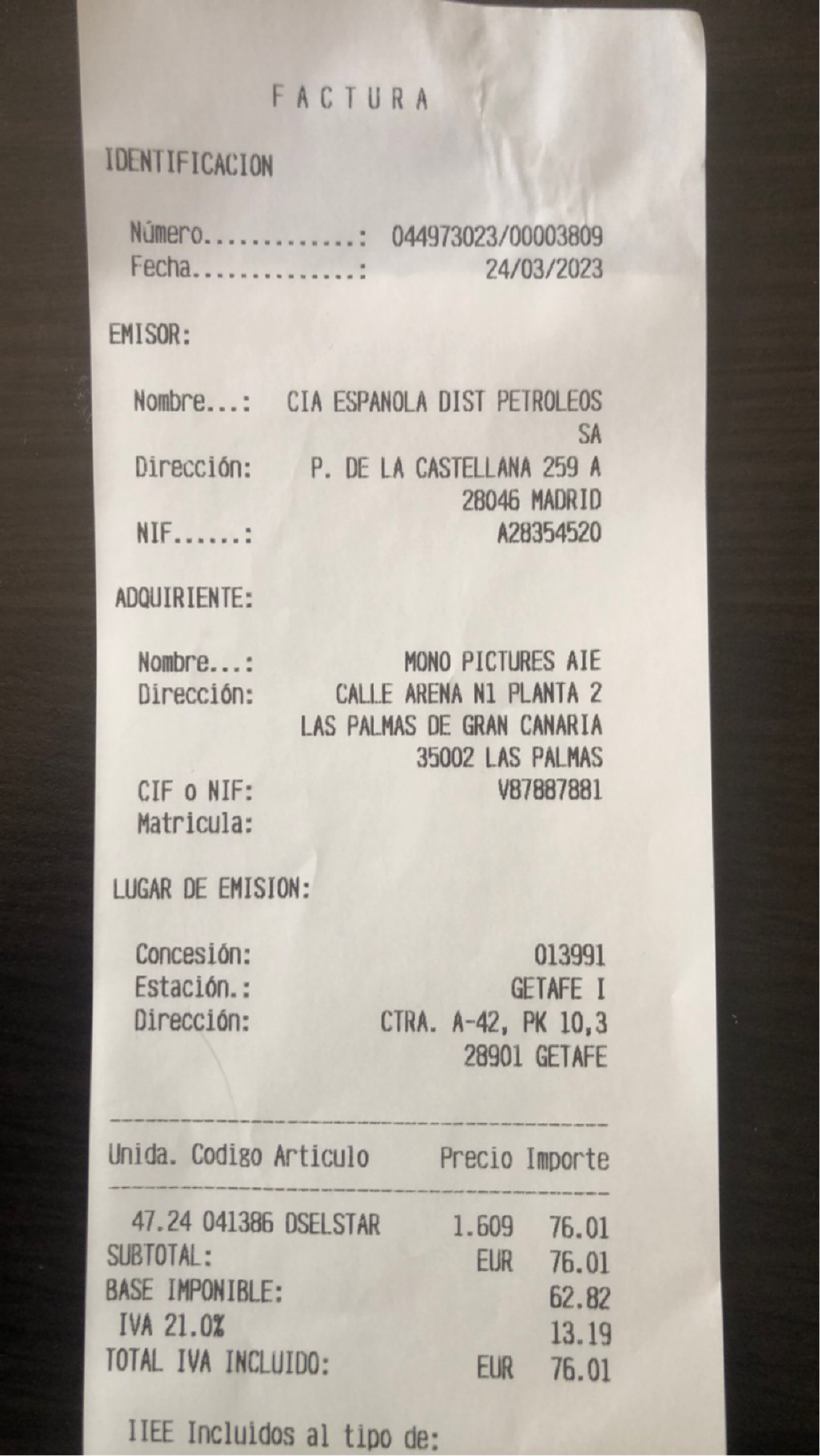

In [ ]:
inspect(6)

# NER Model for Information Extraction



```
# This is formatted as code
```

Does not work, yet
Problem is also that most labels are not found in the OCR output
-> This would argue that the actual OCR is also a source of the week performance

Final steps:
Get this code to run
Test if final model allows to find more invoice document numbers

In [ ]:
#ocr_output_loaded # contains strings of OCR output
#cifs # labels of cifs
#docs # labels of invoice document no's 

In [ ]:
#inspect(0)

In [ ]:
# Install spaCy and other required libraries

!pip install spacy
!pip install spacy-lookups-data

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 8.3 MB/s eta 0:00:00


In [ ]:
# 2. Import libraries
import spacy
import random
from spacy.util import minibatch, compounding
from spacy.training import Example

In [ ]:
# 3. Prepare your training data:
#Create a list of dictionaries with the text and the corresponding entity annotations (start and end indices for invoice number and VAT number). Replace the sample data below with your own labeled data.

TRAIN_DATA = [
    {
        "text": "Sample receipt text 1 with invoice number 12345 and VAT 987654321",
        "entities": [(37, 42, "INVOICE_NUMBER"), (51, 60, "VAT_NUMBER")]
    },
    {
        "text": "Sample receipt text 2 with invoice number 67890 and VAT 012345678",
        "entities": [(37, 42, "INVOICE_NUMBER"), (51, 60, "VAT_NUMBER")]
    },
    # Add more labeled examples
]

In [ ]:
# Now need to replicate with real training data
# Issue: Labels do not have positions 
# -> find positions via a function
# -> if label is not found within the text, assign a random position

# Had created a function that randomly assigns position if label is not found in the text
# 242 positions had been randomly assigned
# That is too much, so I modified the function to only keep instances, where both lables (VAT-number and invoice document no.) were found in the text

In [ ]:
# Function to assign positions to labels, random assignment, if label is not found

import random

def generate_training_data(texts, invoice_numbers, vat_numbers):
    training_data = []
    random_assignments = 0

    for text, invoice_number, vat_number in zip(texts, invoice_numbers, vat_numbers):
        entities = []

        invoice_start = text.find(invoice_number)
        if invoice_start != -1:
            invoice_end = invoice_start + len(invoice_number)
        else:
            max_invoice_start = max(0, len(text) // 2 - len(invoice_number))
            invoice_start = random.randint(0, max_invoice_start)
            invoice_end = invoice_start + len(invoice_number)
            random_assignments += 1
        entities.append((invoice_start, invoice_end, "INVOICE_NUMBER"))

        vat_start = text.find(vat_number)
        if vat_start != -1:
            vat_end = vat_start + len(vat_number)
        else:
            min_vat_start = len(text) // 2
            max_vat_start = max(min_vat_start, len(text) - len(vat_number))
            vat_start = random.randint(min_vat_start, max_vat_start)
            vat_end = vat_start + len(vat_number)
            random_assignments += 1
        entities.append((vat_start, vat_end, "VAT_NUMBER"))

        training_data.append({"text": text, "entities": entities})

    print(f"Randomly assigned labels: {random_assignments}")
    return training_data


In [ ]:
## Function that only keeps instance where both labels are found

def generate_training_data(texts, invoice_numbers, vat_numbers):
    training_data = []

    for text, invoice_number, vat_number in zip(texts, invoice_numbers, vat_numbers):
        invoice_start = text.find(invoice_number)
        vat_start = text.find(vat_number)

        if invoice_start != -1 and vat_start != -1:
            entities = []

            invoice_end = invoice_start + len(invoice_number)
            entities.append((invoice_start, invoice_end, "INVOICE_NUMBER"))

            vat_end = vat_start + len(vat_number)
            entities.append((vat_start, vat_end, "VAT_NUMBER"))

            training_data.append({"text": text, "entities": entities})

    return training_data


In [ ]:
training_dataset = generate_training_data(ocr_output_loaded, docs, cifs)

In [ ]:
len(training_dataset)
## now only 5 instances left

5

In [ ]:
print(len(ocr_output_loaded))
print(len(docs))
print(len(cifs))

150
150
150


In [ ]:
# 4. Create a blank model and add the NER component
nlp = spacy.blank("en")
ner = nlp.add_pipe("ner")

In [ ]:
# 5. Add the custom labels to the NER component:

for annotations in training_dataset:
    for ent in annotations["entities"]:
        ner.add_label(ent[2])

In [ ]:
# 6. Train the model

# Train the model
for i in range(n_iter):
    random.shuffle(training_dataset)
    losses = {}

    # Batch the data using spaCy's minibatch
    batches = minibatch(training_dataset, size=compounding(4.0, 32.0, 1.001))
    for batch in batches:
        texts = [item["text"] for item in batch]
        annotations = [item["entities"] for item in batch]
        examples = [Example.from_dict(nlp.make_doc(text), {"entities": ann}) for text, ann in zip(texts, annotations)]
        nlp.update(examples, sgd=optimizer, losses=losses)

    print("Losses:", losses)


/usr/local/lib/python3.9/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "EA O O O 222222 220202 2222)
 
 
 
 
Factura
Pagad..." with entities "[(191, 216, 'INVOICE_NUMBER'), (624, 633, 'VAT_NUM...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


KeyError: ignored

In [ ]:
# 7. Test the trained model

test_text = "Test receipt text with invoice number 11111 and VAT 222222222"
doc = nlp(test_text)

for ent in doc.ents:
    print(ent.text, ent.start_char, ent.end_char, ent.label_)

In [ ]:
# 8. Save the trained model

nlp.to_disk("/content/drive/MyDrive/NER_model")

In [ ]:
# Load the saved model
nlp_loaded = spacy.load("/content/drive/MyDrive/NER_model")